In [1]:
from datasets import load_dataset
import os
import pandas as pd

d:\llms\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## load a pretraining dataset to perform some data cleaning steps to ensure quality...
pretraining_dataset = load_dataset(
    "upstage/Pretraining_Dataset",
    cache_dir="../../assets/data",
    split="train"
)

In [3]:
#### print an example of pretraining dataset...
print(pretraining_dataset[540]['text'])

"SEVENTEEN SHADES OF LOVE": After her divorce Julia was able to take everything under control and to move on. She became successful and happy. There is no place for romance in her life. But is it possible to live without love?
"A HAPPY ENDING IN A BIG CITY": She travels from one city to another, meeting the same kind of men who always abandon her. She doesn't know that the true love is waiting for her far, far away.
And more stories... They are nostalgic and dreamy but by no means they are fantasy or fairy tales. These romance stories center around ordinary people who are swept away by love and passion. It is all truth.
Adventurous and glamorous things might happen to everyone. They happen to all of us although sometimes we just don't realize.
Available on Amazon in Kindle and Paperback editions. Also on Audiobook (Russian edition only).
​Modern art is often scoffed at. There are many just don't get it - the unrestrained translation of mind in our visible space. The others have no way 

In [4]:
### load an instruction dataset to compare it to the pretraining dataset...
instruction_dataset = load_dataset(
    "gbharti/finance-alpaca",
    cache_dir = "../../assets/data"
)

In [5]:
### show an example of instruction dataset, and compare it to the pretraining dataset examples...
instruction_dataset['train'][500]

{'text': '',
 'instruction': 'Should you co-sign a personal loan for a friend/family member? Why/why not?',
 'input': '',
 'output': 'I know this question has a lot of answers already, but I feel the answers are phrased either strongly against, or mildly for, co-signing. What it amounts down to is that this is a personal choice. You cannot receive reliable information as to whether or not co-signing this loan is a good move due to lack of information. The person involved is going to know the person they would be co-signing for, and the people on this site will only have their own personal preferences of experiences to draw from. You know if they are reliable, if they will be able to pay off the loan without need for the banks to come after you.  This site can offer general theories, but I think it should be kept in mind that this is wholly a personal decision for the person involved, and them alone to make based on the facts that they know and we do not.'}

### Conclusion:

- pretraining examples are large text chunks.
- Instruction dataset examples are (Instruction, Input, Output)

In [6]:
### first I will load any language model tokenizer.
### I will use it to count the number of tokens in pretraining examples..
from transformers import AutoTokenizer

gpt2_tokenizer = AutoTokenizer.from_pretrained(
    "gpt2"
)

d:\llms\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def tokens_histogram(data, col, title):
    token_cnts = [len(gpt2_tokenizer.tokenize(example[col])) for example in data]
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_cnts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (4496 > 1024). Running this sequence through the model will result in indexing errors


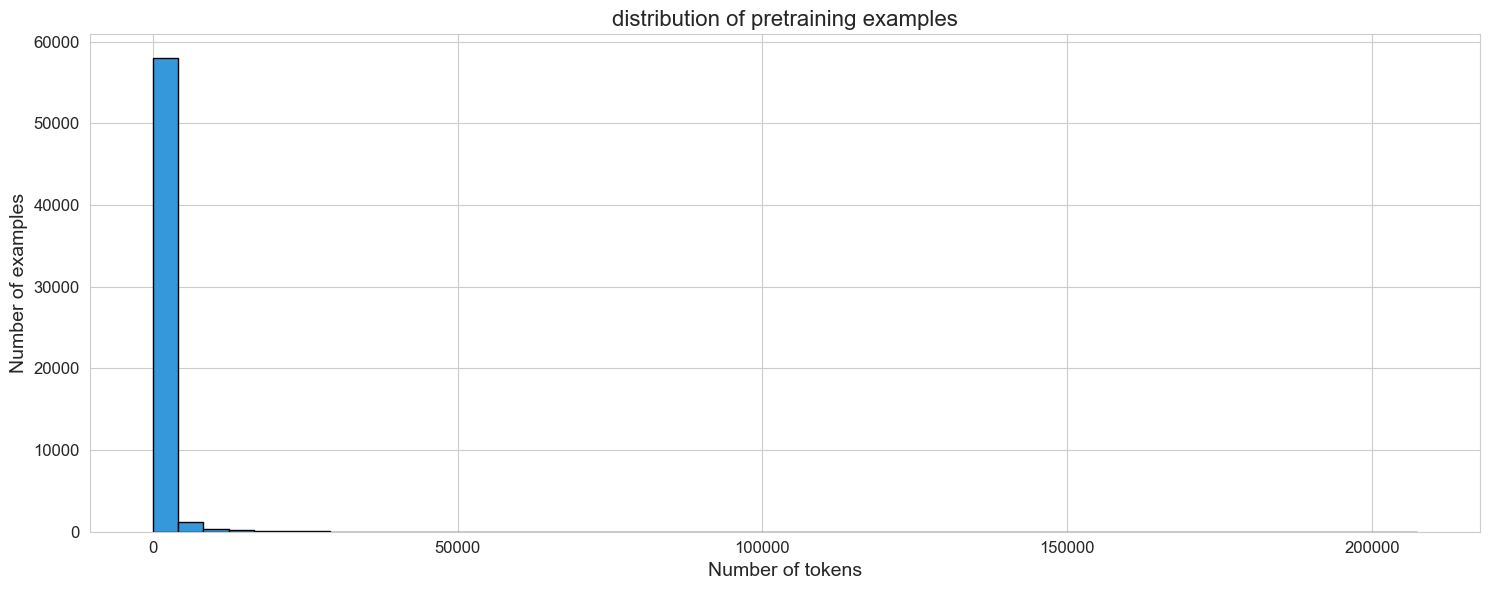

In [8]:
tokens_histogram(pretraining_dataset, "text", "distribution of pretraining examples")

In [8]:
### let's now remove short examples that have less than 4 lines...
import heapq

def length_filter(x):
    lines = x['text'].split("\n")
    if (
        len(lines) < 4
        or min(heapq.nlargest(4, [len(line) for line in lines])) < 4
    ):
        return False
    return True

In [9]:
cleaned_pretraining_dataset = pretraining_dataset.filter(
    length_filter,
    load_from_cache_file=False
)

Filter: 100%|██████████| 60000/60000 [00:07<00:00, 7637.66 examples/s] 


In [10]:
### number of examples decreased from 60K to nearly 48K...
cleaned_pretraining_dataset.num_rows

48278

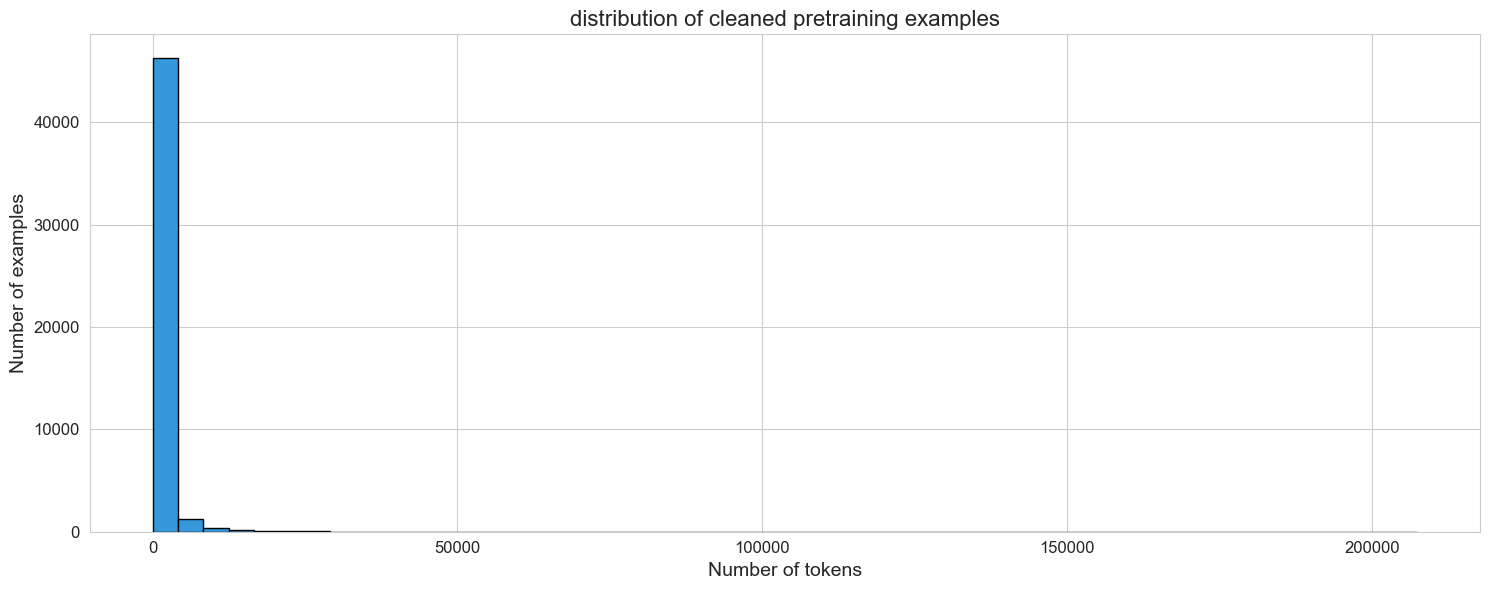

In [12]:
tokens_histogram(cleaned_pretraining_dataset, "text", "distribution of cleaned pretraining examples")

In [28]:
### filter out non-english text...
### try pycld2 as our language detector....
import pycld2 as cld2

isReliable, textBytesFound, details, vectors = cld2.detect(
    pretraining_dataset[540]['text'],
    returnVectors = True
)

vectors

((0, 4373, 'ENGLISH', 'en'),)

In [30]:
def filter_non_english(example):
    filtered = ""
    """Filter out non-English words from a list of words."""
    try:
        isReliable, textBytesFound, details, vectors = cld2.detect(
            example['text'],
            returnVectors = True
        )
    except cld2.error:
        isReliable = False
    if isReliable:
        for vector in vectors:
            if vector[3] == "en":
                filtered += example['text'][vector[0]:vector[1]]
        return filtered

In [31]:
cleaned_pretraining_dataset = cleaned_pretraining_dataset.filter(
    filter_non_english,
    load_from_cache_file=False
)

Filter:   0%|          | 0/48278 [00:00<?, ? examples/s]

Filter: 100%|██████████| 48278/48278 [00:33<00:00, 1423.25 examples/s]


In [32]:
cleaned_pretraining_dataset.num_rows

45681

In [51]:
def deduplication(data):
    def dedup_func(x):
        if x['text'] in unique_text:
            return False
        else:
            unique_text.add(x['text'])
            return True

    unique_text = set()

    data = data.filter(dedup_func, load_from_cache_file=False)
    return data

In [52]:
### remove duplicate text chunks..
cleaned_pretraining_dataset = deduplication(cleaned_pretraining_dataset)

Filter: 100%|██████████| 45681/45681 [00:07<00:00, 6228.34 examples/s] 


In [54]:
cleaned_pretraining_dataset.num_rows

38058

In [56]:
def find_duplicates(sentence):
    unique = set()
    duplicate_chars = 0
    duplicate_element = 0
    for element in sentence:
        if element in unique:
            duplicate_chars += len(element)
            duplicate_element += 1
        else:
            unique.add(element)
    return duplicate_chars, duplicate_element

In [50]:
import re

def filter_repetation(x):
    text = x['text']
    paragraphs = re.compile(r"\n{2,}").split(text.strip())
    paragraphs_duplicates, char_duplicates = find_duplicates(paragraphs)
    if paragraphs_duplicates / len(paragraphs) > 0.3:
        return False
    if char_duplicates / len(text) > 0.2:
        return False
    return True

In [57]:
### remove chunks that has duplications in its elements...

cleaned_pretraining_dataset = cleaned_pretraining_dataset.filter(
    filter_repetation,
    load_from_cache_file=False
)

Filter:   0%|          | 0/38058 [00:00<?, ? examples/s]

Filter: 100%|██████████| 38058/38058 [00:19<00:00, 1945.01 examples/s]


In [59]:
### save to disk..
cleaned_pretraining_dataset.to_parquet('../../assets/data/cleaned_english_pretraining_data.parquet')

Creating parquet from Arrow format: 100%|██████████| 38/38 [00:07<00:00,  5.20ba/s]


191775098